## Проверка гипотезы и составление аналитической записки

- Автор: Максим Ровный 

## Цели и задачи проекта

* Проверка гипотезы в Python и составление аналитической записки
    * Проверка гипотезы, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Для проверки данной гипотезы будет применена односторонняя проверка с двумя выборками.
        * Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.
        * Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.
    * Выгрузить данные из заранее предобработанного датасета в SQL
    * Провести предобработку данных, удалить лишние столбцы, проверить на наличие явных дубликатов, сгруппировать данные по пользователям 

## Описание данных
'/datasets/litres_data.csv'
* city - город пользователя;
* puid - уникальный идентификатор пользователя;
* hours - суммарное количество часов, проведённых пользователем за чтением и прослушиванием книг в приложении.

## Содержимое проекта

1. Загрузка данных и предобработка. 
2. Проверка гипотезы в Python.
3. Аналитическая записка.

## 1. Загрузка данных и знакомство с ними

Загрузим данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания)

In [10]:
import pandas as pd

In [11]:
df_litres_data = pd.read_csv('/data/litres_data.csv')

In [12]:
display(df_litres_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


None

In [13]:
display(df_litres_data.head())

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [14]:
# Удалим ненужный столбец 'Unnamed: 0'
df_litres_data = df_litres_data.drop(columns=['Unnamed: 0'])

In [15]:
# Проверим на наличие дубликатов в идентификаторах пользователей
df_litres_data['puid'].duplicated().sum()

244

In [16]:
# Проверим на наличие явных дубликатов
df_litres_data.duplicated().sum()

0

Явные дубликаты не обнаружены, значит скорее всего, пользователи с одинаковым идентификатором совершали действия в разных городах.

In [17]:
# Группируем данные по идентификатору пользователя и суммируем время активности (часы).
# Если после группировки количество дубликатов не уменьшится,
# значит некоторые пользователи использовали приложение в двух разных городах.
# Для корректности A/B-теста таких пользователей следует удалить,
# чтобы обеспечить независимость групп по городам.
df_litres_data.groupby('puid', as_index=False)['hours'].sum()

,puid,hours
0,9668,26.167776
1,16598,82.111217
2,80401,4.656906
3,104923,60.353889
4,140205,1.840556
...,...,...
8535,1130000059999641,0.081234
8536,1130000060143349,0.024736
8537,1130000060647736,0.209018
8538,1130000061443598,20.847222


In [18]:
# Проверим на наличие дубликатов в идентификаторах пользователей
df_litres_data['puid'].duplicated().sum()

244

Количество дубликатов по столбцу 'puid' осталось прежним. Для корректности A/B-теста таких пользователей следует удалить.

In [20]:
# Посчитаем количество уникальных городов для каждого пользователя
user_city_counts = df_litres_data.groupby('puid')['city'].nunique()
multi_city_users = user_city_counts[user_city_counts > 1].index

# Удалим пользователей с двумя городами из исходного датафрейма
df_clean = df_litres_data[~df_litres_data['puid'].isin(multi_city_users)]

Не будем использовать drop_duplicates, так как это не удалит всех дублирующихся по городу пользователей, а просто оставит первую попавшуюся строку для каждого puid

In [21]:
print(len(df_clean))

8296


In [22]:
df_clean.groupby('city')['hours'].describe()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Москва,5990.0,10.848192,36.925622,0.000022,0.057042,0.888232,5.933439,857.209373
Санкт-Петербург,2306.0,11.264433,39.831755,0.000025,0.060173,0.875355,6.138424,978.764775


* В исходном датафрейме было 8540 строк 
* Пользователей с двумя городами 244 
* В исправленном датафрейме 8296 строк

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [23]:
from scipy.stats import ttest_ind

In [24]:
# Создадим новый датафрейм. На всякий случай еще раз сгруппируем по пользователям и городам 
df_users = df_clean.groupby(['puid', 'city'], as_index=False)['hours'].sum()

moscow = df_users[df_users['city'] == 'Москва']['hours']
spb = df_users[df_users['city'] == 'Санкт-Петербург']['hours']

stat, p_value = ttest_ind(spb, moscow, equal_var=False, alternative='greater')

print(f'p-value: {p_value:.4f}')

p-value: 0.3318


In [25]:
df_users.groupby('city')['hours'].mean()

city
Москва             10.848192
Санкт-Петербург    11.264433
Name: hours, dtype: float64

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

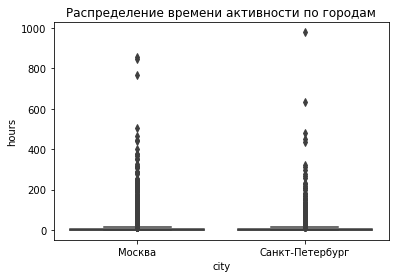

In [27]:
# Взглянем на выбросы
sns.boxplot(data=df_users, x='city', y='hours')
plt.title('Распределение времени активности по городам')
plt.show()

## 3. Аналитическая записка

- Провели односторонний t-тест для независимых выборок с неравной дисперсией.

- p-value = 0.3318.

- Данное значение существенно выше стандартного уровня значимости 0.05, что означает, что полученная разница в среднем времени между городами может быть случайной, нулевая гипотеза не отклонена.

- Визуальный анализ распределения показал наличие выбросов. Некоторые пользователи проводили в приложении значительно больше времени, чем остальные. Это влияет на значение p-value. Еще одним фактором высокого значения p-value является малый размер выборки.

